# Vehicle Detection

## Goals
Detection and tracking of vehicle on the road in near real-time. 

## Implementation Overview
1. Color histogram feature extraction
2. Spatial bins subsamples feature extraction
3. HOG feature extraction
2. SVM linear classifier trained on a labeled binary class dataset
3. Sliding window search with temporal heatmap false-positive reduction

## Libraries

In [3]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import time
from moviepy.editor import VideoFileClip

## Defaults Setup

In [4]:
plt.rcParams['figure.figsize'] = [14,8]
plt.rcParams['figure.frameon'] = False
plt.rcParams['figure.edgecolor'] = 'none'  
plt.rcParams['figure.facecolor'] = 'none' 
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['ytick.labelright'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labeltop'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.subplot.hspace'] = 0.01
plt.rcParams['figure.subplot.wspace'] = 0.01
plt.rcParams['image.interpolation'] = 'bilinear'

## Load Dataset

### Load Vehicle Class Data

In [5]:
VEHICLE_PATH = './vehicles/**/*.png'
vehicle_paths = vehicle = glob.glob(VEHICLE_PATH)
vehicle = [cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1] for path in vehicle_paths]

### Load Not-Vehicle Class Data

In [6]:
NOT_VEHICLE_PATH = './non-vehicles/**/*.png'
not_vehicle_paths = glob.glob(NOT_VEHICLE_PATH)
not_vehicle = [cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1] for path in not_vehicle_paths]

## Exploratory Analysis
__TODO__: what classes do we have? plot a few samples from each placemove loading the dataset to another place. where will we need to find these (larger image) ? show example images. How do their histograms compare? what about hog ? gradient? what about spatial pixel correlation? 

### Sample Count, Dimensionality, Data Type

In [7]:
print('vehicle sample count:',len(vehicle))
print('vehicle image shape:',vehicle[0].shape)
print('vehicle data type:',vehicle[0].dtype)

vehicle sample count: 8792
vehicle image shape: (64, 64, 3)
vehicle data type: uint8


In [8]:
print('not vehicle sample count:',len(not_vehicle))
print('not vehicle image shape:',not_vehicle[0].shape)
print('not vehicle data type:',not_vehicle[0].dtype)

not vehicle sample count: 8968
not vehicle image shape: (64, 64, 3)
not vehicle data type: uint8


### Class Showcase

#### Not-Vehicles

True

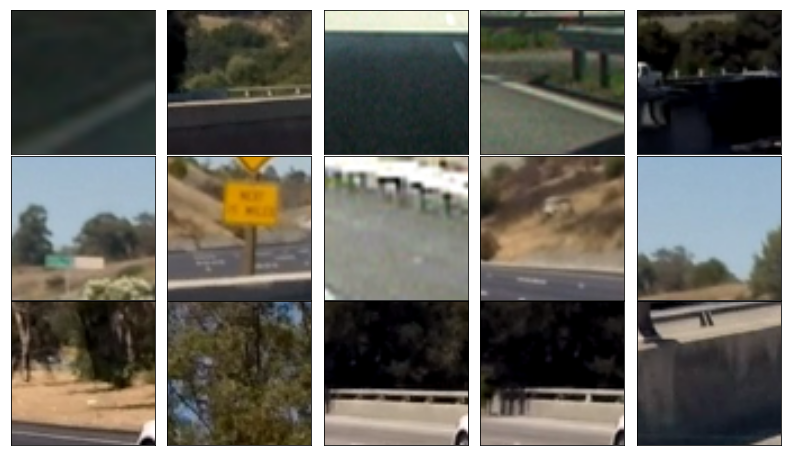

In [56]:
all(ax.imshow(im) for im,ax in zip(not_vehicle[:15], plt.subplots(3,5)[1].ravel()))

#### Vehicles

True

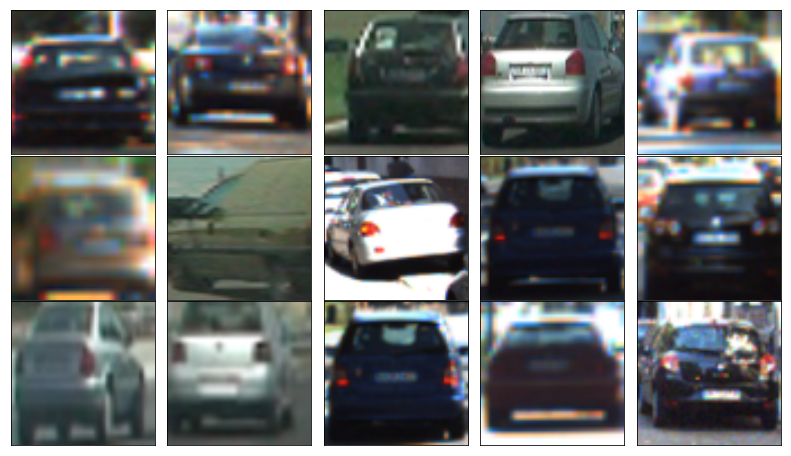

In [79]:
all(ax.imshow(im) for im,ax in zip(vehicle[:15], plt.subplots(3,5)[1].ravel()))

### Histogram Comparison

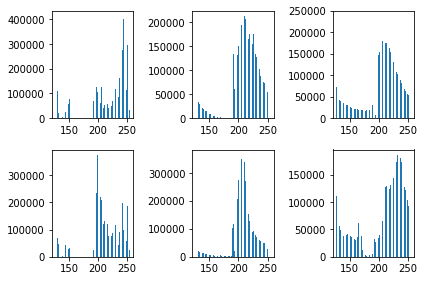

In [46]:
ax = plt.subplots(2,3)[1]
for i in range(3):
    hist = ax[0][i].hist(vehicle[...,i].flatten(),bins=256)
    hist = ax[1][i].hist(not_vehicle[...,i].flatten(),bins=256)
plt.tight_layout()

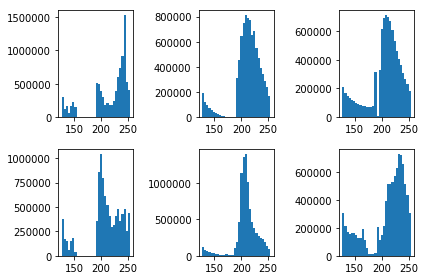

In [48]:
ax = plt.subplots(2,3)[1]
for i in range(3):
    hist = ax[0][i].hist(vehicle[...,i].flatten(),bins=32)
    hist = ax[1][i].hist(not_vehicle[...,i].flatten(),bins=32)
plt.tight_layout()

## Feature Extractions
We extract 3 kinds of features:
1. HLS color histogram
2. Downsampled bins
3. HOG

### Data Preparation
We combine both sample classes for preprocessing. 

In [9]:
x_data = vehicle+not_vehicle
len(x_data)

17760

### Color Histogram
We produce a color histogram for each channel, we then flatten and concatenate to produce the feature map. HLS color space was selected due to anecdotic correlation with better accuracy during experimintation.

#### Color Transformation


In [195]:
def color_transform(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#### Histogram Computation

In [196]:
def extract_hist(img):
    hist = list(map(lambda i: np.histogram(img[...,i], bins=64, range=(0,256))[0], range(3))) 
    return np.concatenate((hist[0], hist[1],hist[2]))

## Spatial Binning of Color
We produce spatial color bins by downsampling and flattening out input images. This feature map is an indicator of correlation between individual pixel values. (32,32) pixel size was selected empirically. 

In [197]:
def extract_spatial(img):
    return cv2.resize(img, (32,32), interpolation=cv2.INTER_LINEAR).ravel()

### HOG 
We compute a Histogram of Oriented Gradients for classifier feature input. The HOG feature map provides a scale invariant gradient description of our classification targets. We've set the parameters as follows: `orientations=9`, `pixels_per_cell=(8,8)`, `cells_per_block=(4,4)`. Parameters values were set after an extended period of empirical tunning and provide a compromise between performance and classification accuracy. Only a single channel was used for HOG feature extraction due to seemingly negligble effect on accuracy.

In [198]:
def extract_hog(img):
    return hog(img[...,2],9,(8,8),(4,4),'L2-Hys',False,False,True)    

### Combining Features

In [199]:
def combine_features(cf,sf,hf):
    return np.concatenate((cf,sf,hf))

### Composite Extraction Pipeline

In [200]:
def extract_features(img):
    img = color_transform(img)
    cf,sf,hf = extract_hist(img), extract_spatial(img), extract_hog(img)
    return combine_features(cf,sf,hf)

In [201]:
combined_f = list(map(lambda im: extract_features(im), x_data))
len(combined_f)

17760

## Classification Preprocessing

### Stacking

In [202]:
X = np.vstack(combined_f).astype(np.float64)
X.shape

(17760, 6864)

### Labeling
We've attached binary labels corresponding to our target classes: `0:non-vehicle`, `1:vehicle`. 

In [203]:
y = np.concatenate((np.ones(len(vehicle),np.bool), np.zeros(len(not_vehicle),np.bool)))
y.shape

(17760,)

### Randomization

In [204]:
X,y = shuffle(X,y)

### Test Validation Split

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Normalization
The data is normalized per column based on training features. Thereafter, the same extracted parameters are used to normalize the validation and production input.

In [206]:
X_scaler = StandardScaler().fit(X_train)  # fit scaler to traianing data
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [207]:
def normalize(samples):
    return X_scaler.transform(samples)

## SVM Classifier
We'll use a linear SVM - ???? whats that?

### SVC Training
We've utilized randomized grid hyperparameter search to estimate optimal classifier kernel and penalty values. We've found the RBF kernel to offer greater accuracy, however its prediction time is too long for real time usage. Therefore, we've chosen the linear classifier with a penalty ('C' value) of 1. 

In [208]:
svc = LinearSVC()
svc.fit(X_train, y_train)
print(' Done Training')

 Done Training


### SVC Evaluation

#### Test Accuracy

In [209]:
print(' Test Accurcay =', round(svc.score(X_test, y_test), 4))

 Test Accurcay = 0.9854


#### Prediction Time

In [210]:
t=time.time(); n_predict = 1000;  svc.predict(X_test[0:n_predict]); t2 = time.time()
print('',round(t2-t, 5), 'Seconds to predict', n_predict,'labels')

 0.00759 Seconds to predict 1000 labels


## Sliding Window Search
We've implemented a uniform-dimension sliding window search. The top and bottom (sky and hood) are discarded as they're outside our ROI. A temporal prediction heatmap is implemented in the video pipeline section.

In [129]:
def slide_window(img, size, overlap):
    sy, sx = np.mgrid[352:544:int(size*overlap), 0:1280:int(size*overlap)]
    sy, sx = sy.ravel(), sx.ravel()
    return list(map(lambda y,x: (img[y:y+size,x:x+size],(x,y)), sy,sx))

### Detection Visualization
We draw a rectangle extended from the base window detection coordinates.

In [130]:
def vis_detection(img, pred, win, size):
    imout = img.copy()
    pos = np.argwhere(pred==True)
    cord = np.array(win)[pos][...,1][...,0]
    for c in cord:
        cv2.rectangle(imout, c,(c[0]+size,c[1]+size) , (0, 0, 255), 3)
    return imout

### Test Image

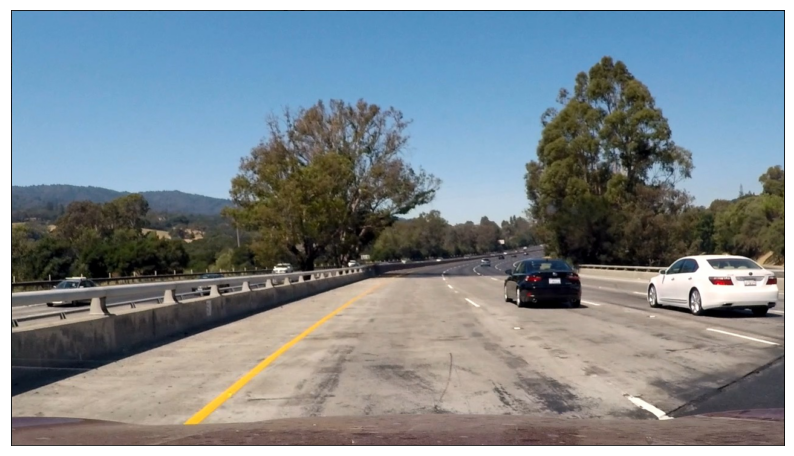

In [654]:
img = cv2.imread('./test_images/test1.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
plt.imshow(img)

### Small Sliding Window
Small windows reliably provide multiple detections per vehicles. However, they also produce a lot of false positives and carry a significant performance penalty. 

In [590]:
small_window_list = slide_window(img, 64, 1.0)

True

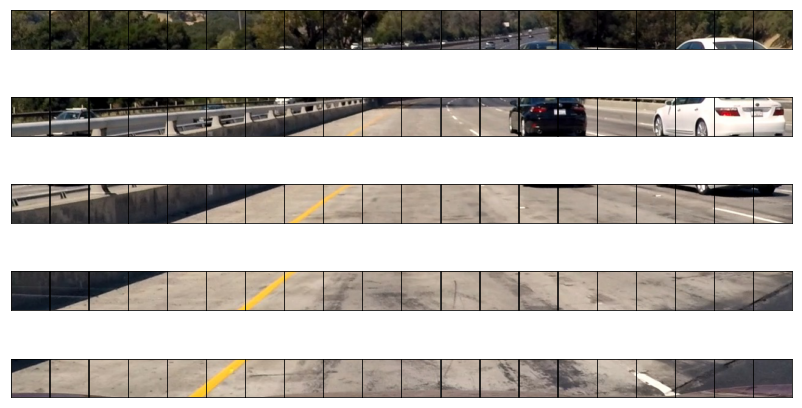

In [584]:
all(ax.imshow(win[0]) for ax,win in zip(plt.subplots(5,20)[1].ravel(),small_window_list))

#### Classification

In [591]:
f_list = list(map(lambda im: extract_features(im[0]), small_window_list))
pred = svc.predict(normalize(f_list))
pred

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False], dtype=bool)

#### Bounding Boxes

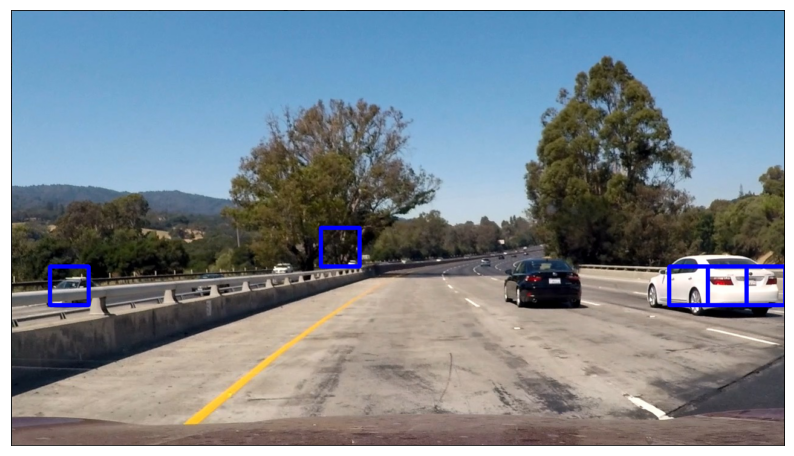

In [592]:
imout = vis_detection(img, pred, small_window_list,64)
plt.imshow(imout)

### Medium Sliding Window
Medium windows (128x128 pixels) were found to be unreliable, even when combined with a generous overlap factor.

In [655]:
medium_window_list = slide_window(img, 128, 1.0)

True

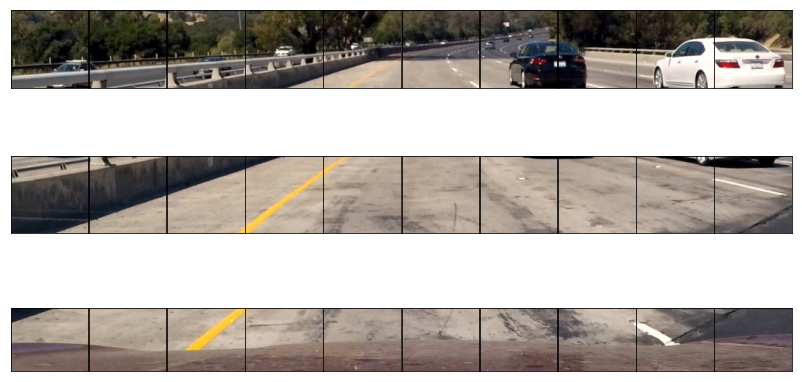

In [598]:
all(ax.imshow(im[0]) for ax,im in zip(plt.subplots(3,10)[1].ravel(),medium_window_list))

#### Classification

In [656]:
f_list = list(map(lambda im: extract_features(cv2.resize(im[0],(64,64))), medium_window_list))
pred = svc.predict(normalize(f_list))
pred

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

#### Bounding Boxes

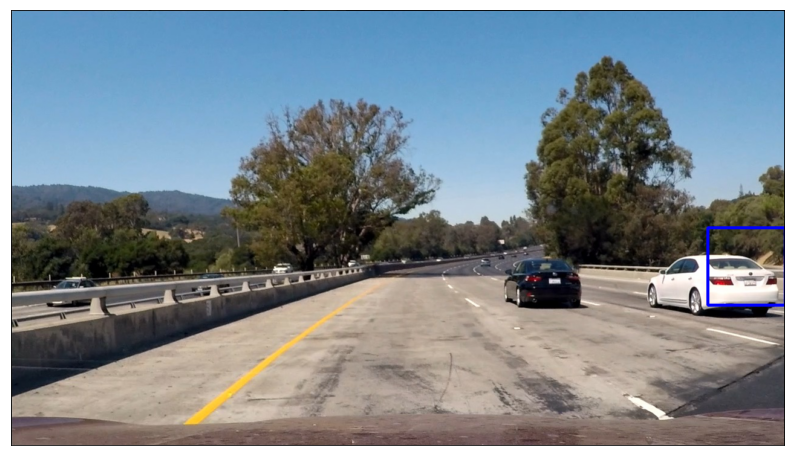

In [657]:
imout = vis_detection(img, pred, medium_window_list,128)
plt.imshow(imout)

#### Medium Window at Half Overlap

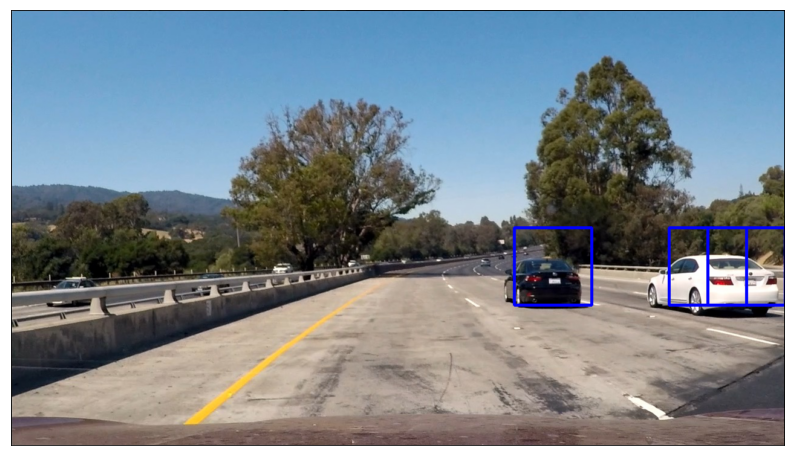

In [660]:
medium_window_list = slide_window(img, 128, 0.5)
f_list = list(map(lambda im: extract_features(cv2.resize(im[0],(64,64))), medium_window_list))
pred = svc.predict(normalize(f_list))
imout = vis_detection(img, pred, medium_window_list,128)
plt.imshow(imout)       

#### Large Sliding Window
Large windows were practically unusable without further dataset augmentation.

In [605]:
large_window_list = slide_window(img, 256, 1.0)

True

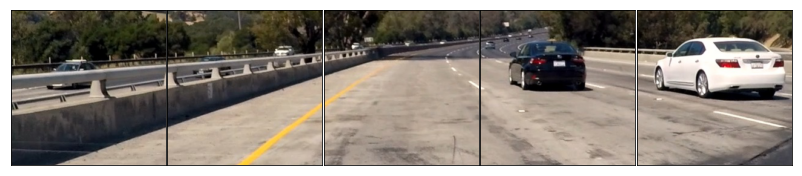

In [606]:
all(ax.imshow(im[0]) for ax,im in zip(plt.subplots(1,5)[1].ravel(),large_window_list))

#### Classification

In [607]:
f_list = list(map(lambda im: extract_features(cv2.resize(im[0],(64,64))), large_window_list))
pred = svc.predict(normalize(f_list))
pred

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

## Video Pipeline
The main distinction of the video pipeline is the addition of a temporal heatmap. The heatmap is implemented as an array of counters. Whereupon predictions are recognized as genuine when high counter values are reached.

In [211]:
WINDOW_SIZE = 64
def process(img):
    windows = slide_window(img, WINDOW_SIZE, 1.0)
    features = list(map(lambda im: extract_features(cv2.resize(im[0],(64,64))), windows))
    predictions = svc.predict(normalize(features))
    process.heat = np.where(predictions==True,process.heat+1, process.heat-1)
    process.heat = np.where(process.heat<1, 1, process.heat)
    process.heat = np.where(process.heat>16, 16, process.heat)
    area_heat = np.convolve(process.heat,np.ones(3)/3, mode='same').astype(np.uint8)
    predictions = np.where(process.heat>8, True, False)
    img = vis_detection(img, predictions, windows ,WINDOW_SIZE)
    return img
process.heat = np.ones(60, dtype=np.uint8)

In [214]:
video = VideoFileClip("project_video.mp4")
video = VideoFileClip("test_video.mp4")
processed_video = video.fl_image(process)
processed_video.write_videofile("output_video.mp4", audio=False, progress_bar=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



## Discussion

Firsly, there are a lof of false-positives. There's much improvment to be gained by data augmentation
and classifier tweaking. 

Secondly, The implementation is doesn't make use of possible data parallelism. 
There's much room for improvment in this regard. Currently, the model suffers from very low overall performance.
Furthermore, Some features are re-computed multiple times.

Thirdly, and most obviously, no detection blending (combining smaller detections) was implemented. 

Lastly, no multi-scale, adaptive, randomized, etc sliding window techniques were used. 